# LightGBM : SKLearn API GridSearch

Read Titanic Data

Split Data : Train, Validation, Test 

Convert Data to LGBM Data Structure

Build Model using SKLearn API

Model using Cross-Validation 

Model using GridSearchCV, RandomizedSearchCV

Predict 

Performnace Measure 

Plot Merics

SHAP Analysis

Probability Calibration 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [2]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
import lightgbm as lgb

In [4]:
try:
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

### Read Data

In [5]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [6]:
# """CatBoost"""
# from catboost.datasets import titanic
# train_df, test_df = titanic()

In [7]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(np.nan, inplace=True)
# test_df.fillna(np.nan, inplace=True)

In [8]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [9]:
from ipynb.fs.full.dataProcessing_titanicData import *

In [10]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [11]:
feature_names = X.columns.tolist()
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_names = X.columns[ categorical_features_indices ].tolist()
print(f"Total Features : {feature_names}" )
print(f"Categorical Features : {categorical_features_names}" )

Total Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'NameLength', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Boat', 'LastName', 'Title', 'HomeDest']
Categorical Features : ['Pclass', 'SibSp', 'Parch', 'NameLength', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Boat', 'LastName', 'Title', 'HomeDest']


In [12]:
theSeed = 209
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (706, 14)
valid data: (236, 14)


In [13]:
#X_test = test_df
X_test = test_df.drop('Survived', axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (367, 14)


#### LGBM Data Structure

In [14]:
train_data = lgb.Dataset(
    data=X_train, 
    label=y_train, 
    feature_name=feature_names, 
    categorical_feature=categorical_features_names,
    weight=None, 
    free_raw_data=False)

valid_data = lgb.Dataset(
    data=X_valid, 
    label=y_valid, 
    reference=train_data, 
    weight=None, 
    free_raw_data=False)

#### Setting Weight to the Data

In [15]:
# w = np.random.rand(X_train.shape[0], )
# train_data = lgb.Dataset(data=X_train, label=y_train, weight=w)
# train_data.set_weight(w)

### Training Model

#### Cross-Validation 

In [16]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

In [17]:
cvmodel = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    n_estimators=100, 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    subsample_for_bin=200000, 
    objective='binary', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,  
    importance_type='split', #'gain'
    silent=True)

In [18]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5, verbose=False)

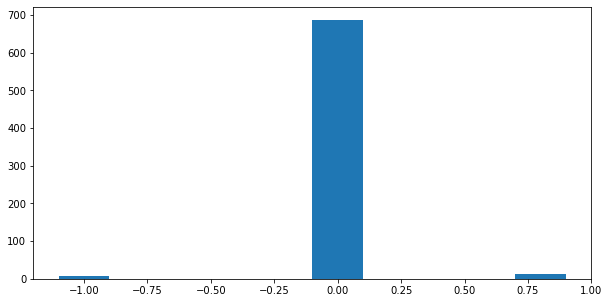

[0.00991501 0.         0.         0.         0.         0.97308782
 0.         0.         0.         0.01699717]


In [19]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)
plt.show()
print( n/len(y_pred) )

In [20]:
# fig, ax = plt.subplots( figsize=(12,7) )
# ax.scatter(y_train.to_numpy(), y_pred, edgecolors=(0, 0, 0))
# ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
# ax.set_xlabel('Observed')
# ax.set_ylabel('Predicted')
# plt.show()

In [21]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

array([0.95774648, 0.9787234 , 0.9787234 , 0.97163121, 0.9787234 ])

In [22]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy', 'roc_auc', 'f1'], cv=5)
scores

{'fit_time': array([0.05179811, 0.03688288, 0.04412389, 0.05619097, 0.05426216]),
 'score_time': array([0.0065279 , 0.00643826, 0.00627303, 0.00816584, 0.00648904]),
 'test_accuracy': array([0.95774648, 0.9787234 , 0.9787234 , 0.97163121, 0.9787234 ]),
 'test_roc_auc': array([0.98349007, 0.997463  , 0.99957717, 0.97547569, 0.9820296 ]),
 'test_f1': array([0.94444444, 0.97196262, 0.97345133, 0.96296296, 0.97247706])}

#### GridSearch Cross-Validation

In [23]:
param_grid = {
    'n_estimators': [60,80,100],
    'learning_rate': [0.01, 0.1, 1],
    'min_split_gain' : [0.0, 0.05, 0.1],
    'min_child_weight': [0.0005, 0.001, 0.005],
    'min_child_samples': [20,25,30], 
    'subsample': [0.85,0.9, 1.0], 
    'subsample_freq': [0,1,2], 
    'colsample_bytree':[0.9, 0.95, 1.0],
    'reg_alpha' : [0.0], 
    'reg_lambda': [0.0]
}

In [24]:
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    objective='binary',
    class_weight=None,
    random_state=42,
    n_jobs=-1,  
    importance_type='split', #'gain'
    silent=True)

In [25]:
#from sklearn.metrics import SCORERS
#SCORERS.keys()

In [26]:
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, refit=True)
#grid_search = GridSearchCV(model, param_grid, scoring=['roc_auc','neg_log_loss',f1'], cv=5, refit='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary', random_state=42),
             param_grid={'colsample_bytree': [0.9, 0.95, 1.0],
                         'learning_rate': [0.01, 0.1, 1],
                         'min_child_samples': [20, 25, 30],
                         'min_child_weight': [0.0005, 0.001, 0.005],
                         'min_split_gain': [0.0, 0.05, 0.1],
                         'n_estimators': [60, 80, 100], 'reg_alpha': [0.0],
                         'reg_lambda': [0.0], 'subsample': [0.85, 0.9, 1.0],
                         'subsample_freq': [0, 1, 2]},
             scoring='roc_auc')

In [27]:
print("Best Estimator:", grid_search.best_estimator_)
print("Best Index    :", grid_search.best_index_)
print("Best Params   :", grid_search.best_params_)
print("Best Score    :", grid_search.best_score_)
print("Best Classes  :", grid_search.classes_)

Best Estimator: LGBMClassifier(colsample_bytree=0.9, learning_rate=0.01, min_child_samples=30,
               min_child_weight=0.0005, n_estimators=80, objective='binary',
               random_state=42, subsample=0.9, subsample_freq=2)
Best Index    : 500
Best Params   : {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'min_child_samples': 30, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 2}
Best Score    : 0.9948997594226142
Best Classes  : [0 1]


In [28]:
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_colsample_bytree',
 'param_learning_rate',
 'param_min_child_samples',
 'param_min_child_weight',
 'param_min_split_gain',
 'param_n_estimators',
 'param_reg_alpha',
 'param_reg_lambda',
 'param_subsample',
 'param_subsample_freq',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [29]:
means = grid_search.cv_results_['mean_test_score']
stds  = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.993 (+/-0.011) for {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 60, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 0}
0.993 (+/-0.011) for {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 60, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 1}
0.993 (+/-0.011) for {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 60, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 2}
0.993 (+/-0.011) for {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'min_child_samples': 20, 'min_child_weight': 0.0005, 'min_split_gain': 0.0, 'n_estimators': 60, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 0}
0.993 (+/-0.011) for {'colsam

0.991 (+/-0.012) for {'colsample_bytree': 0.9, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 0}
0.987 (+/-0.017) for {'colsample_bytree': 0.9, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 1}
0.936 (+/-0.214) for {'colsample_bytree': 0.9, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 2}
0.991 (+/-0.012) for {'colsample_bytree': 0.9, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_freq': 0}
0.991 (+/-0.012) for {'colsample_bytree': 0.

0.988 (+/-0.018) for {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 0}
0.990 (+/-0.014) for {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 1}
0.990 (+/-0.013) for {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 2}
0.988 (+/-0.018) for {'colsample_bytree': 0.95, 'learning_rate': 0.1, 'min_child_samples': 25, 'min_child_weight': 0.001, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 0}
0.991 (+/-0.013) for {'colsample_

0.990 (+/-0.020) for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 2}
0.991 (+/-0.014) for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_freq': 0}
0.991 (+/-0.014) for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_freq': 1}
0.991 (+/-0.014) for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_freq': 2}
0.992 (+/-0.014) for {'colsample

0.948 (+/-0.174) for {'colsample_bytree': 1.0, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.85, 'subsample_freq': 2}
0.989 (+/-0.022) for {'colsample_bytree': 1.0, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 0}
0.991 (+/-0.013) for {'colsample_bytree': 1.0, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 1}
0.917 (+/-0.298) for {'colsample_bytree': 1.0, 'learning_rate': 1, 'min_child_samples': 25, 'min_child_weight': 0.005, 'min_split_gain': 0.1, 'n_estimators': 80, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 2}
0.989 (+/-0.022) for {'colsample_bytree': 1.0, 

#### Best Model Evaluation

In [30]:
"""Get the Best Estimator"""
bestEstimator = grid_search.best_estimator_

In [31]:
"""Build the Best Model using the Best Estimator"""
bestEstimator.fit(
    X_train, y_train,  
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc', 
    early_stopping_rounds=None,
    verbose=False)

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.01, min_child_samples=30,
               min_child_weight=0.0005, n_estimators=80, objective='binary',
               random_state=42, subsample=0.9, subsample_freq=2)

In [32]:
# fit = model.fit(
#     X_train, y_train,
#     eval_set=[(X_valid, y_valid)],
#     eval_metric='auc', 
#     early_stopping_rounds=None, 
#     verbose=False)

In [33]:
auc = list(bestEstimator.evals_result_.values())[0]['auc']
auc = np.array(auc)
print(f"Mean AUC : { round(auc.mean(),4) }")
loss = list(bestEstimator.evals_result_.values())[0]['binary_logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4) }")

Mean AUC : 0.9931
Mean Loss : 0.4354


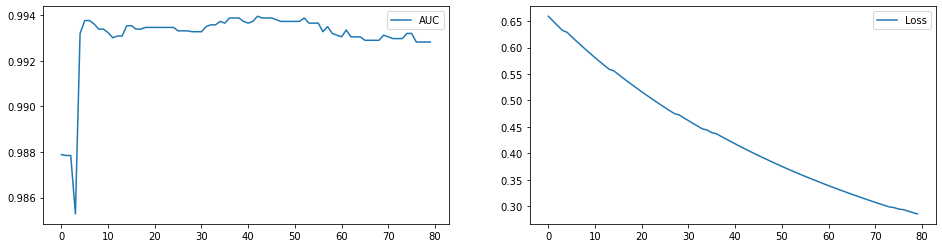

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

### Predict

In [35]:
y_pred = grid_search.predict(X_test)

In [36]:
y_score = grid_search.predict_proba(X_test)

### Performance Metrics

In [37]:
from sklearn import metrics

In [38]:
"""Accuracy Score"""
accuracy = metrics.accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.97


In [39]:
"""Balanced Accuracy Score"""
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.9635


In [40]:
"""ROC Curve"""
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

In [41]:
"""AUC"""
auc = metrics.auc(fpr, tpr)
print( round(auc, 4))

0.9937


In [42]:
"""Confusion Matrix"""
metrics.confusion_matrix(y_test, y_pred)

array([[231,   3],
       [  8, 125]])

In [43]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:231, FP:3, FN:8, TP:125


In [44]:
"""F1 Score"""
f1 = metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9579


In [45]:
"""Log Loss"""
metrics.log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.29345585393769574

In [46]:
"""Precision, Recall, Fscore, Support"""
metrics.precision_recall_fscore_support(y_test, y_pred, labels=[0,1], pos_label=1, 
                                        average=None, sample_weight=None)

(array([0.9665272, 0.9765625]),
 array([0.98717949, 0.93984962]),
 array([0.97674419, 0.95785441]),
 array([234, 133]))

In [47]:
precision = metrics.precision_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                                    average='binary', sample_weight=None)
print( round(precision, 4))

0.9766


In [48]:
recall = metrics.recall_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                              average='binary', sample_weight=None)
print( round(recall, 4))

0.9398


Basic Plots

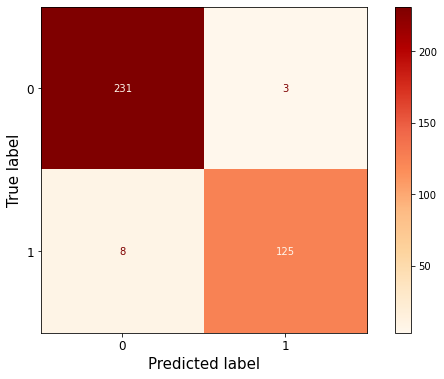

In [49]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)

metrics.plot_confusion_matrix(grid_search, X_test, y_test, 
                              labels=None, sample_weight=None, normalize=None, 
                              display_labels=[0,1], 
                              cmap='OrRd', 
                              #color='w',
                              ax=ax)

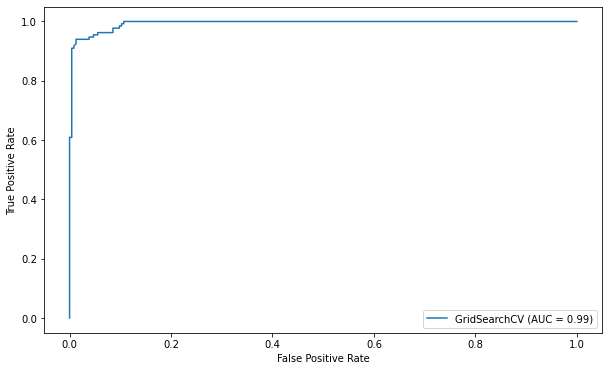

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_roc_curve(grid_search, X_test, y_test, sample_weight=None, ax=ax)

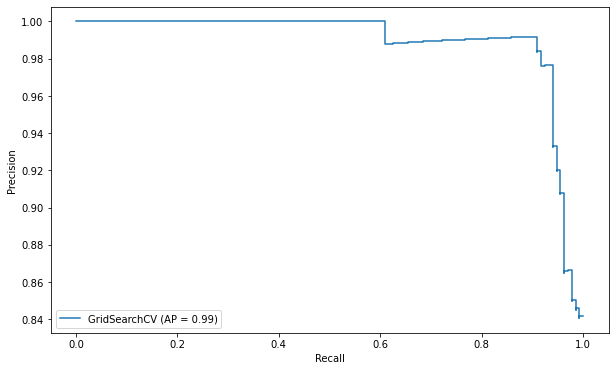

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_precision_recall_curve(grid_search, X_test, y_test, sample_weight=None, ax=ax)

### SHAP Analysis

In [52]:
import shap
shap.initjs()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [53]:
explainer = shap.Explainer(grid_search.best_estimator_)
shap_values = explainer(X_train)

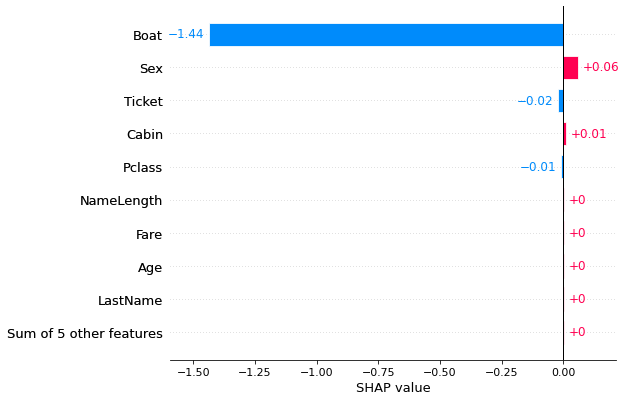

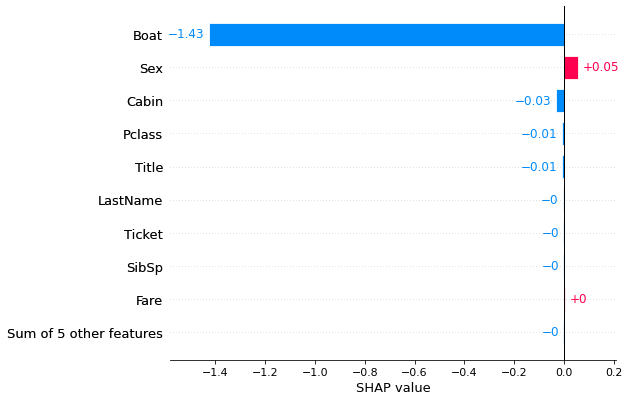

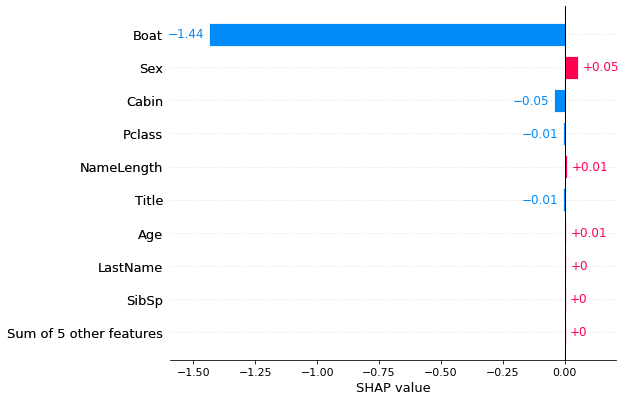

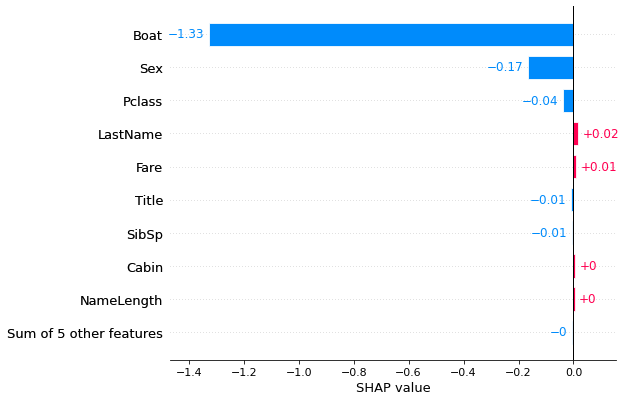

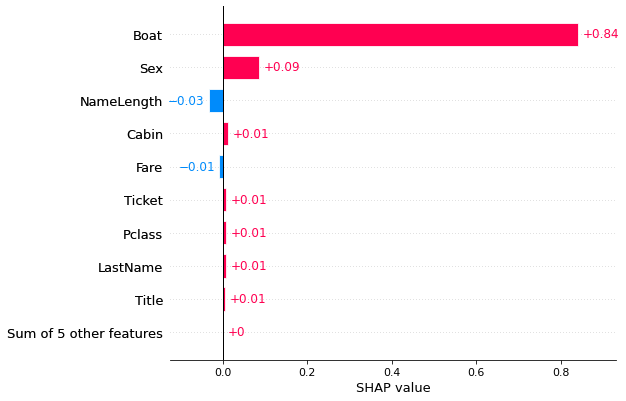

In [54]:
for i in range(5):
    shap.plots.bar(shap_values[:,:,0][i])

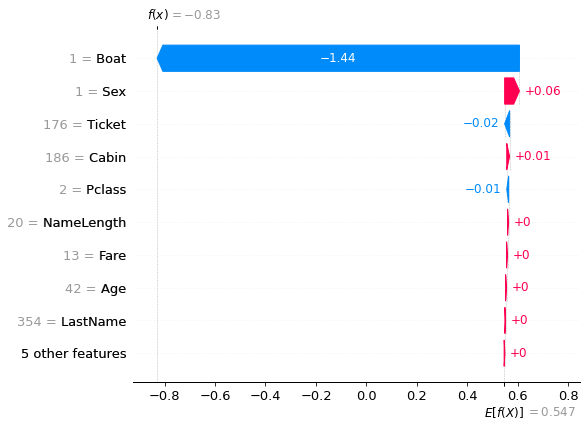

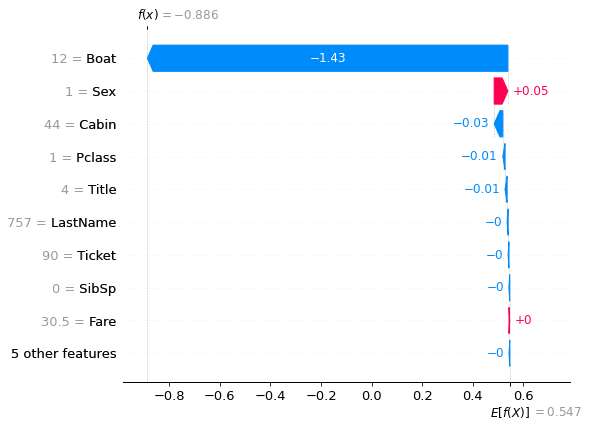

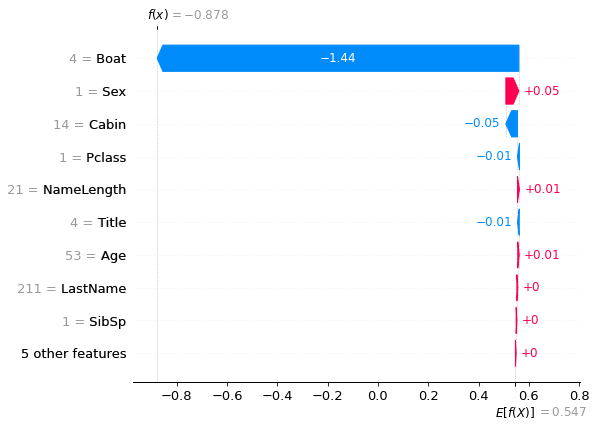

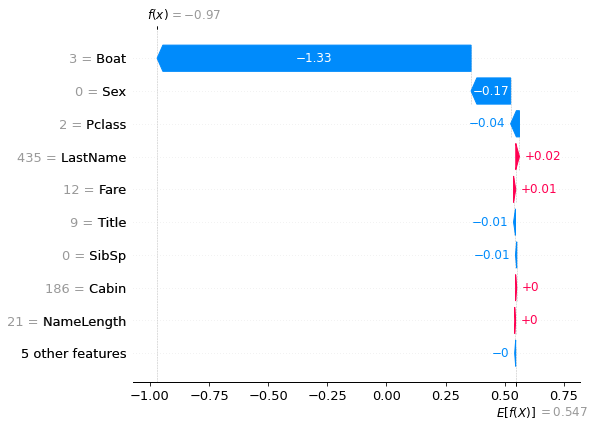

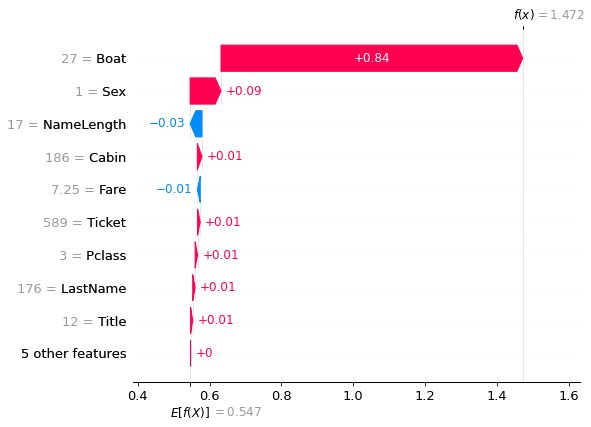

In [55]:
for i in range(5):
    shap.plots.waterfall(shap_values[:,:,0][i])

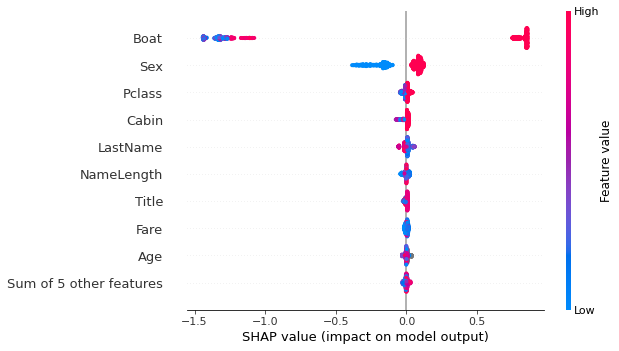

In [56]:
shap.plots.beeswarm(shap_values[:,:,0])

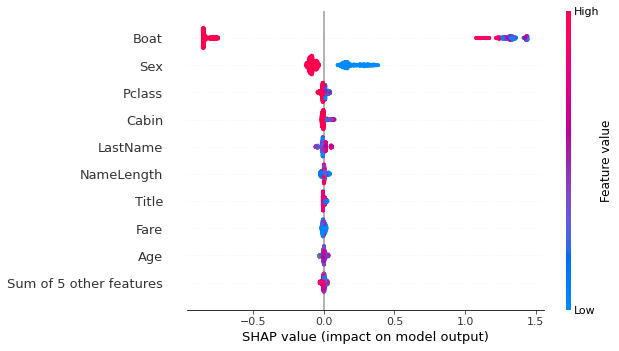

In [57]:
shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
treeExplainer = shap.TreeExplainer(grid_search.best_estimator_, 
                               data=None, 
                               feature_perturbation= "tree_path_dependent", 
                               model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [59]:
shap.force_plot(treeExplainer.expected_value[1], shap_values[1][:100,:], X_train.iloc[0:100,:])

SHAP Summary Plot

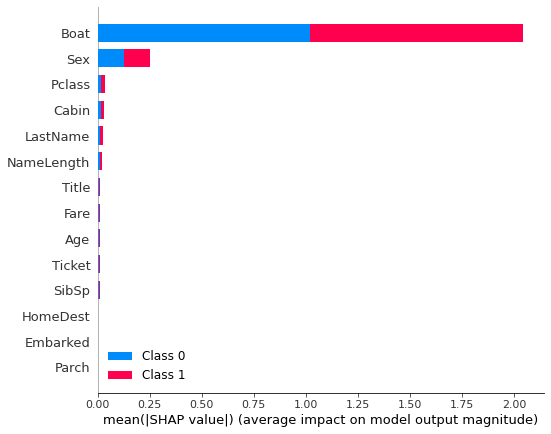

In [60]:
shap.summary_plot(shap_values, X_train)

SHAP Dependence Plot

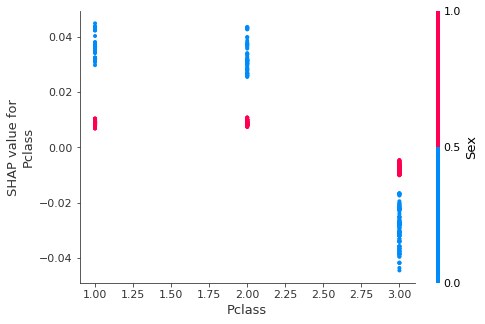

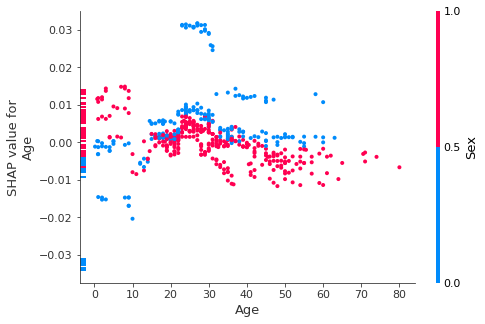

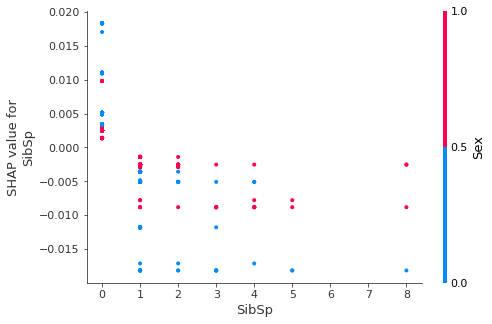

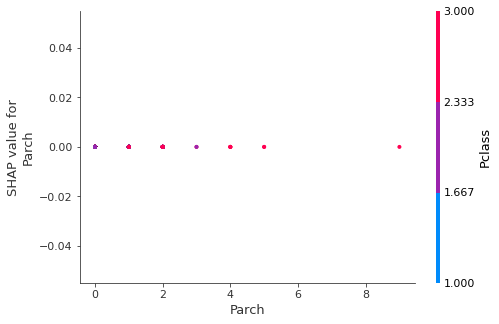

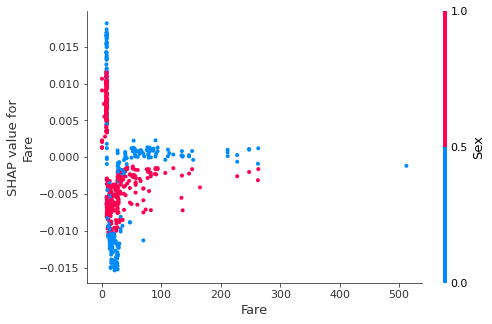

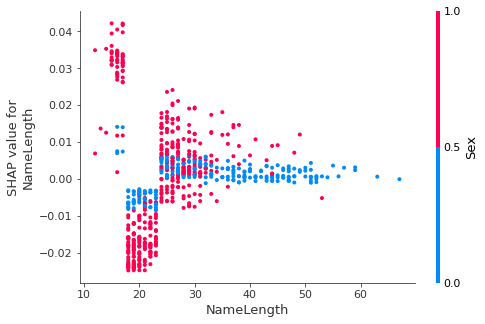

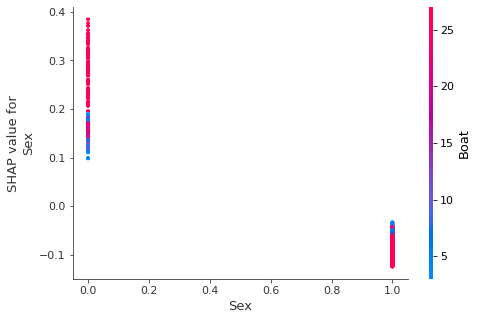

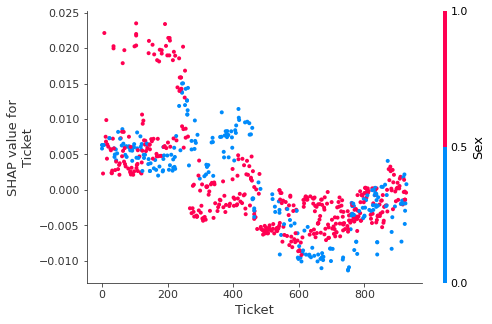

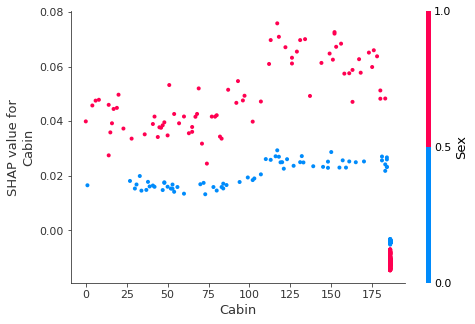

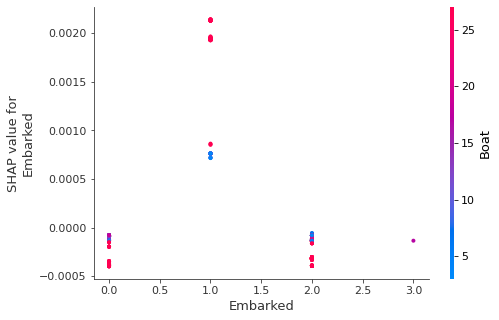

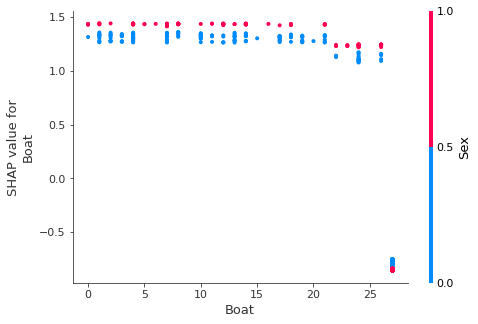

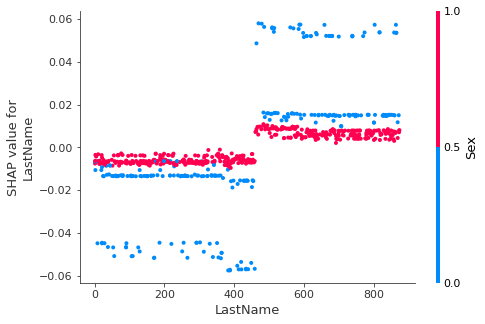

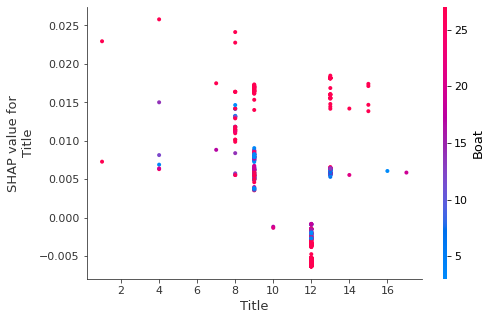

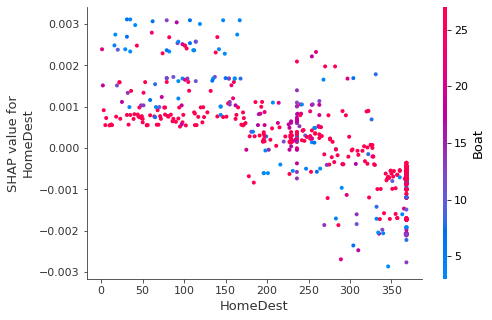

In [61]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_train, display_features=X_train)

### Probability Calibration¶

In [62]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

In [63]:
calibrated_model = CalibratedClassifierCV(base_estimator=grid_search, method='sigmoid', cv='prefit')

In [64]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [65]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

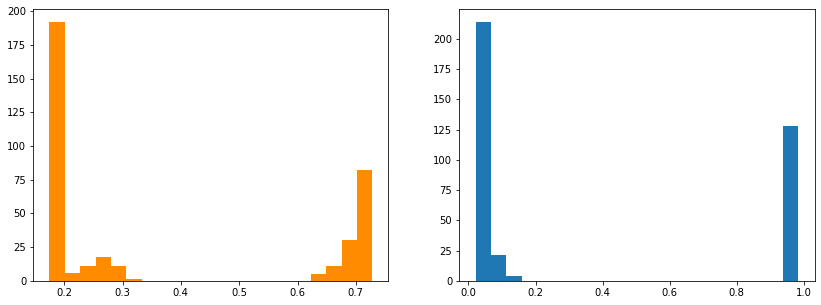

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()

### Randomized GridSearch Cross-Validation

In [67]:
from scipy import stats
from sklearn.utils.fixes import loguniform

In [68]:
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    objective='binary',
    class_weight=None,
    random_state=42,
    n_jobs=-1,  
    importance_type='split', #'gain'
    silent=True)

In [69]:
grid_search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=5, refit=True)
#grid_search = RandomizedSearchCV(model, param_grid, scoring=['accuracy','roc_auc',f1'], cv=5, refit='accuracy')
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=42),
                   param_distributions={'colsample_bytree': [0.9, 0.95, 1.0],
                                        'learning_rate': [0.01, 0.1, 1],
                                        'min_child_samples': [20, 25, 30],
                                        'min_child_weight': [0.0005, 0.001,
                                                             0.005],
                                        'min_split_gain': [0.0, 0.05, 0.1],
                                        'n_estimators': [60, 80, 100],
                                        'reg_alpha': [0.0], 'reg_lambda': [0.0],
                                        'subsample': [0.85, 0.9, 1.0],
                                        'subsample_freq': [0, 1, 2]},
                   scoring='roc_auc')

In [70]:
print("Best Estimator:", grid_search.best_estimator_)
print("Best Index    :", grid_search.best_index_)
print("Best Params   :", grid_search.best_params_)
print("Best Score    :", grid_search.best_score_)
print("Best Classes  :", grid_search.classes_)

Best Estimator: LGBMClassifier(colsample_bytree=0.9, learning_rate=0.01, min_child_samples=25,
               min_split_gain=0.05, n_estimators=80, objective='binary',
               random_state=42, subsample_freq=1)
Best Index    : 2
Best Params   : {'subsample_freq': 1, 'subsample': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'n_estimators': 80, 'min_split_gain': 0.05, 'min_child_weight': 0.001, 'min_child_samples': 25, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best Score    : 0.9935189910330248
Best Classes  : [0 1]
